In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import logging
import numpy as np
from tqdm import tqdm
from seaborn import kdeplot
import matplotlib.pyplot as plt

In [3]:
from simulator.lob import OrderBookSimulator
from scripts.utils.data_loading import get_data_file_paths

In [4]:
logging.getLogger().setLevel(logging.ERROR)

In [5]:
# simualation parameters
DATA_ROOT = '../data/onetick/processed_2/AAPL'
IMPACT_PARAM = 10 ** 8  # large values execute against historic orders
DURATION = 20 * 60  # in seconds
SAMPLING_FREQUENCY = 5  # in seconds, dicated by LOB data
NUM_PERIODS = int(DURATION / SAMPLING_FREQUENCY)
BREAK_PERIOD = 2 * NUM_PERIODS # int(NUM_PERIODS / 2)

# almgren-chris parameters
PLACEMENT_FREQUENCY = 6
ORDER_SIZE = 100
TRADE_SIZE = 2000

In [6]:
simulation_periods = get_data_file_paths(DATA_ROOT)
# simulation_periods = simulation_periods[:100]

In [7]:
def num_assets(N, X, kappa, T=DURATION):
    #T = T / (24 * 60 * 60)
    tau = T / N
    t = np.arange(0, T, tau)
    j = np.arange(1, N + 1)
    tau = T / N
    t_05 = (j - 0.5) * tau
    n_j = X * (2 * np.sinh(0.5 * kappa * tau) / np.sinh(kappa * T)) * np.cosh(kappa * (T - t_05))
    #n_j = np.sinh(kappa * (T - t)) / np.sinh(kappa * T) * X
    n_j2 = np.array([0])
    n_j = np.append(n_j2, n_j)
    t = np.append(t, T)
    return n_j, t

n1, t1 = num_assets(20, TRADE_SIZE, 0.0000000001)
n2, t2 = num_assets(20, TRADE_SIZE, 0.002)
n3, t3 = num_assets(20, TRADE_SIZE, 0.005)

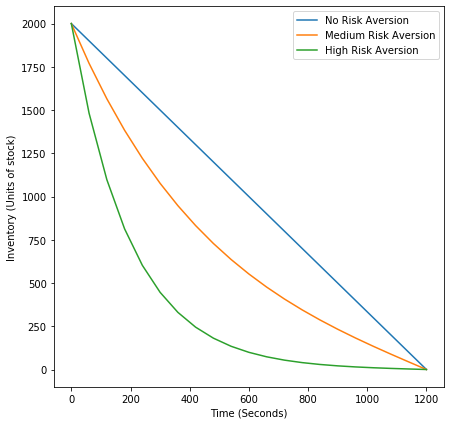

In [8]:
plt.figure(figsize = (7, 7))
plt.plot(t1, TRADE_SIZE - np.cumsum(n1), label = 'No Risk Aversion')
plt.plot(t2, TRADE_SIZE - np.cumsum(n2), label = 'Medium Risk Aversion')
plt.plot(t3, TRADE_SIZE - np.cumsum(n3), label = 'High Risk Aversion')
plt.ylabel('Inventory (Units of stock)')
plt.xlabel('Time (Seconds)')
plt.legend()

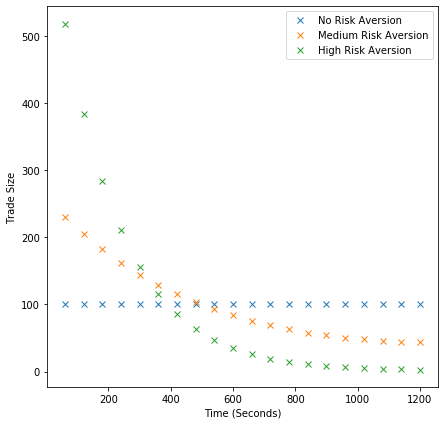

In [9]:
plt.figure(figsize = (7, 7))
plt.plot(t1[1:], n1[1:], 'x', label = 'No Risk Aversion')
plt.plot(t2[1:], n2[1:], 'x', label = 'Medium Risk Aversion')
plt.plot(t3[1:], n3[1:], 'x', label = 'High Risk Aversion')
plt.ylabel('Trade Size')
plt.xlabel('Time (Seconds)')
plt.legend()

### Strategy which places a market sell order every PLACEMENT_FREQUENCY periods

In [10]:
calc_midprice = lambda x: (x.BID_PRICE.max() + x.ASK_PRICE.min()) / 2

In [11]:
def almgren_chris(sim_data_path, mapping, num_periods=NUM_PERIODS, impact_param=IMPACT_PARAM, ):
    
    try:
        
        # set up LOB simulator
        order_book_file = os.path.join(sim_data_path, 'ob.feather')
        trades_file = os.path.join(sim_data_path, 'trades.feather')
        LOB = OrderBookSimulator(order_book_file, trades_file, impact_param)

        # we will save our trade data to these lists
        order_list = []
        midprice_series = []

        for period in range(0, num_periods):

            # advance state
            ob, trds, executed_orders, active_limit_order_levels = LOB.iterate()

            # place sell order
            order_size = mapping[period]
            if order_size > 0:
                LOB.place_market_sell_order(order_size)

            # save data
            midprice_series.append(calc_midprice(ob))
            order_list += executed_orders
            
    except:
        
        order_list = []
        midprice_series = []
    
    return (order_list, midprice_series)

In [12]:
def map_AC_LOB(order_list, periods = NUM_PERIODS):
    mapping = {}
    count = 1
    ord_count = 1
    for i in range(0, periods):
        if i % 12 == 0:
            mapping.update({i : order_list[ord_count]})
            ord_count = ord_count + 1
        else:
            mapping.update({i : 0})
    return mapping

In [13]:
order_lists = [n1, n2, n3]
AC_map = []
for i in order_lists:
    AC_map.append(map_AC_LOB(i))

In [14]:
import multiprocessing as mp
from functools import partial

pool_res = []
for i in tqdm(AC_map):
    AC_partial = partial(almgren_chris, mapping = i)

    with mp.Pool(max(1, mp.cpu_count() - 1)) as pool:
        pool_results = pool.map(AC_partial, simulation_periods)
    pool_res.append(pool_results)

100%|██████████| 3/3 [05:03<00:00, 101.16s/it]


In [15]:
def calculate_shortfall(pool_results):
    ALL_DATA = {}
    for idx, res in enumerate(pool_results):
        if len(res[0]) == 0:
            continue
        ALL_DATA[idx] = {'price_series': res[1], 'executed_orders': res[0]}
    
    shortfall_results = []
    for sim_data_path, sim_results in ALL_DATA.items():
        vol_weighted_price_sum = sum([order['volume'] * order['price'] for order in sim_results['executed_orders']])   
        total_volume = sum([order['volume'] for order in sim_results['executed_orders']])
        vwap = vol_weighted_price_sum / total_volume
        initial_price = sim_results['price_series'][0]
        shortfall = 100 * (vwap - initial_price) / initial_price
        shortfall_results.append(shortfall)
    
    return shortfall_results

In [26]:
shortfall_very_fast = calculate_shortfall(pool_res[2])
very_fast_pool_results = pool_res[2]

In [27]:
shortfall_fast = calculate_shortfall(pool_res[1])

In [28]:
shortfall_slow = calculate_shortfall(pool_res[0])
slow_pool_results = pool_res[0]

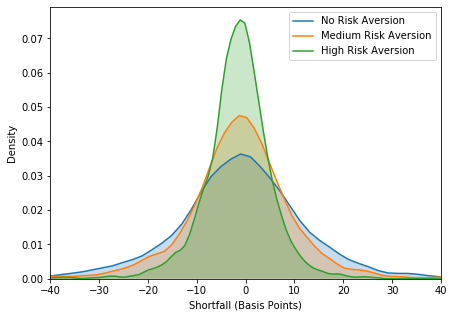

In [63]:
plt.figure(figsize = (7, 5))
kdeplot(100 * np.array(shortfall_slow), shade=True, label='No Risk Aversion', )
kdeplot(100 * np.array(shortfall_fast), shade=True, label='Medium Risk Aversion')
kdeplot(100 * np.array(shortfall_very_fast), shade=True, label='High Risk Aversion')
plt.ylabel('Density')
plt.xlabel('Shortfall (Basis Points)')
plt.xlim((-40, 40))
plt.savefig('kde_almgren_chriss.png', dpi=400)

Text(0, 0.5, 'Probability Density')

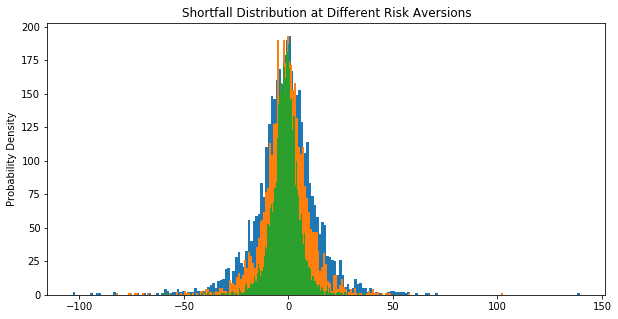

In [56]:
plt.figure(figsize = (10, 5))
plt.hist(100 * np.array(shortfall_slow), 200, label='No Risk Aversion')
plt.hist(100 * np.array(shortfall_fast), 200, label='Medium Risk Aversion')
plt.hist(100 * np.array(shortfall_very_fast), 200, label='High Risk Aversion')
plt.title('Shortfall Distribution at Different Risk Aversions')
plt.ylabel('Probability Density')
# plt.xlim((-0.3, 0.3))

In [31]:
very_fast_mean = np.mean(shortfall_very_fast)
very_fast_std = np.std(shortfall_very_fast)
very_fast_se = very_fast_std / np.sqrt(len(shortfall_very_fast))
print('VERY FAST EXECUTION')
print('Mean Shortfall: %.4f bps +/- %.4f bps' % (100 * very_fast_mean, 100 * very_fast_se))
print('StDev Shortfall: %.4f%%' % very_fast_std)

VERY FAST EXECUTION
Mean Shortfall: -1.6221 bps +/- 0.1130 bps
StDev Shortfall: 0.0713%


In [32]:
fast_mean = np.mean(shortfall_fast)
fast_std = np.std(shortfall_fast)
fast_se = fast_std / np.sqrt(len(shortfall_fast))
print('FAST EXECUTION')
print('Mean Shortfall: %.4f bps +/- %.4f bps' % (100 * fast_mean, 100 * fast_se))
print('StDev Shortfall: %.4f%%' % fast_std)

FAST EXECUTION
Mean Shortfall: -1.3752 bps +/- 0.1800 bps
StDev Shortfall: 0.1136%


In [33]:
slow_mean = np.mean(shortfall_slow)
slow_std = np.std(shortfall_slow)
slow_se = slow_std / np.sqrt(len(shortfall_slow))
print('SLOW EXECUTION')
print('Mean Shortfall:  %.4f bps +/-  %.4f bps' % (100 * slow_mean, 100 * slow_se))
print('StDev Shortfall:  %.4f%%' % slow_std)

SLOW EXECUTION
Mean Shortfall:  -1.2987 bps +/-  0.2359 bps
StDev Shortfall:  0.1489%


In [34]:
very_fast_mean / slow_mean

1.24894775541997

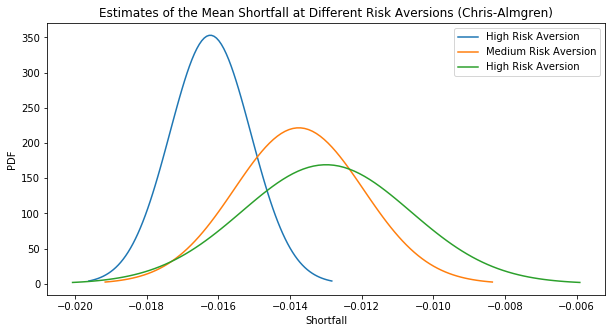

In [35]:
import scipy.stats as stats
import math

mu = very_fast_mean
sigma = very_fast_se
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.figure(figsize = (10, 5))
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='High Risk Aversion')
mu = fast_mean
sigma = fast_se
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='Medium Risk Aversion')
mu = slow_mean
sigma = slow_se
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='High Risk Aversion')
plt.title('Estimates of the Mean Shortfall at Different Risk Aversions (Chris-Almgren)')
plt.ylabel('PDF')
plt.xlabel('Shortfall')
plt.legend()
plt.show()